In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [4]:
dataset = pd.read_csv('A2Q3.csv',header = None)
train_data = dataset.to_numpy()
print(train_data.shape)

# standardize the data
def standardize_mean(data):
    mean = np.mean(data,axis = 0)
    #std = np.std(data,axis = 0)
    data = (data - mean)
    return data

# standardize the data using variance
def standardize_var(data):
    mean = np.mean(data,axis = 0)
    var = np.var(data,axis = 0)
    data = (data - mean)/var
    return data

# standardize the data using min-max
def standardize_minmax(data):
    min = np.min(data,axis = 0)
    max = np.max(data,axis = 0)
    data = (data - min)/(max - min)
    return data

#train_data = standardize_mean(train_data)
#train_data = standardize_var(train_data)
#train_data = standardize_minmax(train_data)

(400, 2)


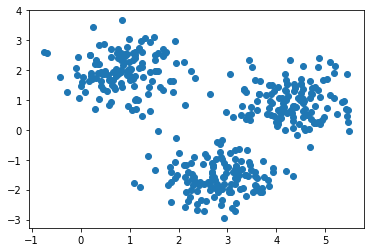

In [5]:
def plot_data(data):
    plt.scatter(data[:,0],data[:,1])
    plt.show()
plot_data(train_data)

In [6]:
# Building GMM model
sic = []
bic = []
# Function for initializing the parameters of GMM model 
def initialize_parameters(K,data):
    N = len(data) # No of data points
    D = len(data[0]) # No of features or dimension of data
    # Initializing the parameters
    pi = np.ones(K)/K
    # splitting the data into K clusters and calculating the mean of each cluster and covariance matrix of each cluster
    # randomizing the data 
    np.random.shuffle(data)
    mean = np.zeros((K,D))
    cov = np.zeros((K,D,D))
    for k in range(K):
        mean[k] = np.mean(data[k::K],axis = 0)
        cov[k] = np.cov(data[k::K].T)
    return pi,mean,cov
def GaussianMixture(data,mean,cov):
    N = len(data)
    D = len(data[0])
    # Calculating the determinant of the covariance matrix
    CovDet = np.linalg.det(cov*np.e)
    CovDet = CovDet/np.e
    # Calculating the inverse of the covariance matrix
    CovInv = np.linalg.inv(cov)
    # Calculating the constant term
    const = 1.0/((2*np.pi)**(D/2)*(CovDet**(1/2)))
    # Calculating the exponential term
    exp = np.zeros(N)
    for i in range(N):
        Centered_x = data[i]-mean
        exp[i] = np.exp(-0.5*np.dot(np.dot(Centered_x,CovInv),Centered_x.T))
    return const*exp

def GMM(NoIterations,ConvergencePoint,K,train_data):
    N = len(train_data) # No of data points
    D = len(train_data[0]) # No of features or dimension of data
    # Initializing the parameters
    pi,mean,cov = initialize_parameters(K,train_data)
    log_likelihood = []
    r = np.zeros((N,K))
    rP = np.zeros((N,K))
    for i in range(NoIterations):
        # E step 
        for k in range(K):
            r[:,k] = pi[k]*GaussianMixture(train_data,mean[k],cov[k])
            rP[:,k] = pi[k]*GaussianMixture(train_data,mean[k],cov[k])
        for n in range(N):
            r[n,:] = r[n,:]/np.sum(r[n,:])
            
        # M step
        Nk = np.sum(r,axis=0)
        for k in range(K):
            pi[k] = Nk[k]/N
            mean[k] = np.dot(r[:,k].reshape(1,N),train_data)/Nk[k]
            Centered_x = np.zeros((N,D))
            for n in range(N):
                Centered_x[n] = train_data[n]-mean[k]
            for n in range(N):
                cov[k] += (r[n,k])*np.dot(Centered_x[n].reshape(D,1),Centered_x[n].reshape(1,D))
            cov[k] = cov[k]/Nk[k]
        
        # Calculating the log likelihood
        log_likelihood.append(0)
        for n in range(N):
            ans = 0
            for k in range(K):
                ans += pi[k]*GaussianMixture(train_data[n].reshape(1,D),mean[k],cov[k])
            log_likelihood[i] += np.log(ans)
        
        if i>0:
            if abs(log_likelihood[i]-log_likelihood[i-1])<ConvergencePoint:
                break
    
    
    print(f"For no of cluster {K} log-likelihood = ",log_likelihood[len(log_likelihood)-1])
    train_dataY = np.zeros(N)
    for n in range(N):
        train_dataY[n] = np.argmax(r[n,:])
    
    #print(train_dataY)
    print(silhouette_score(train_data,train_dataY))
    sic.append(silhouette_score(train_data,train_dataY))

    # bic 
    print(f"For no of cluster {K} bic = ",-2*log_likelihood[len(log_likelihood)-1] + K*np.log(N))
    bic.append(-2*log_likelihood[len(log_likelihood)-1] + K*np.log(N))

    # Plotting the data points with different colors for different clusters
    cmp = plt.cm.get_cmap('viridis', K)
    plt.figure(figsize=(10,10))
    # legend of clusters
    for k in range(K):
        plt.scatter([],[],c=cmp(k/K),label='Cluster '+str(k+1))
    plt.legend()
    # GMM contour plot
    x = np.linspace(np.min(train_data[:,0])-1,np.max(train_data[:,0])+1,300)
    y = np.linspace(np.min(train_data[:,1])-1,np.max(train_data[:,1])+1,300)
    X,Y = np.meshgrid(x,y)
    for k in range(K):
        Z = GaussianMixture(np.c_[X.ravel(),Y.ravel()],mean[k],cov[k])
        Z = Z.reshape(X.shape)
        plt.contour(X,Y,Z)
    
    plt.scatter(train_data[:,0],train_data[:,1],c=train_dataY,cmap=cmp)
    plt.title('Data points with different colors for different clusters for K = '+str(K)+' clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.plot(np.arange(len(log_likelihood)), log_likelihood)
    plt.title('Log-likelihood vs EM iteration plot for K = '+str(K)+' clusters')
    plt.xlabel('EM iteration')
    plt.ylabel('Log-likelihood')
    plt.show()

    #silhouette_score(train_data,train_dataY)
    return pi,mean,cov,log_likelihood


Plots of Q3

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


For no of cluster 2 log-likelihood =  [-1479.10989753]
0.4412436340987868
For no of cluster 2 bic =  [2970.20272415]


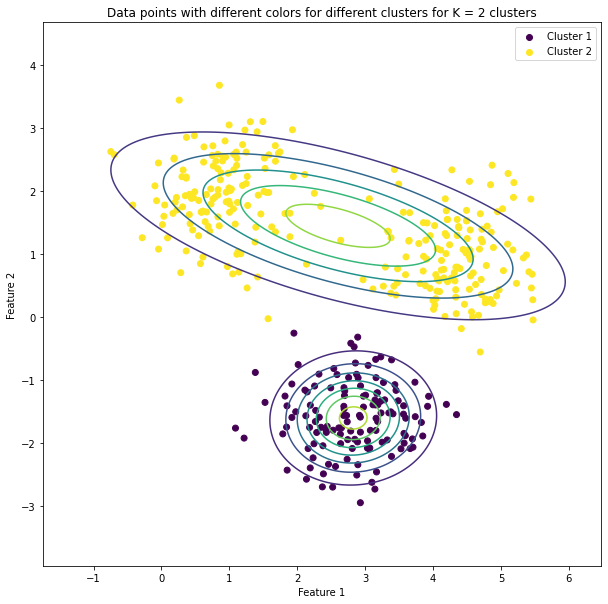

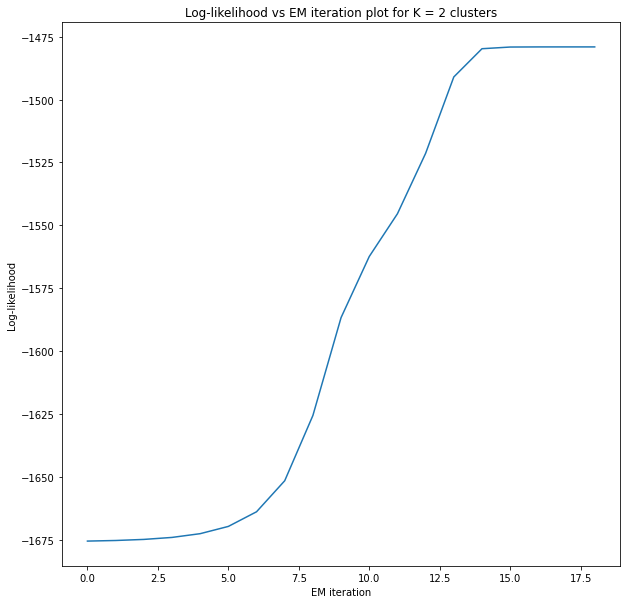

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


For no of cluster 3 log-likelihood =  [-1353.10375588]
0.6586027345896963
For no of cluster 3 bic =  [2724.1819054]


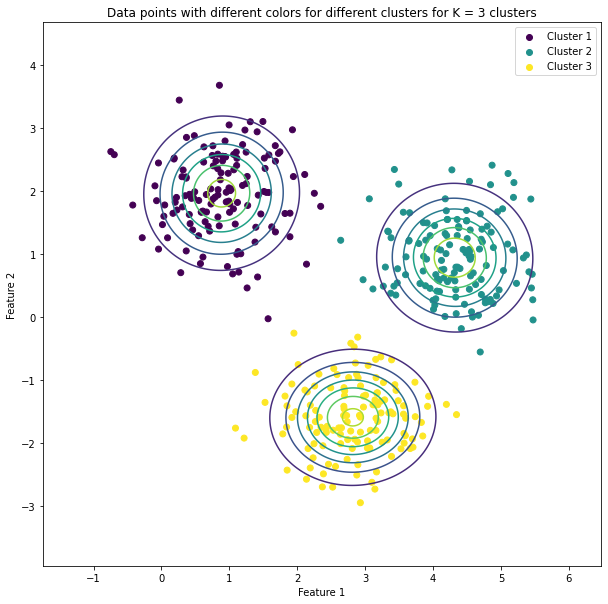

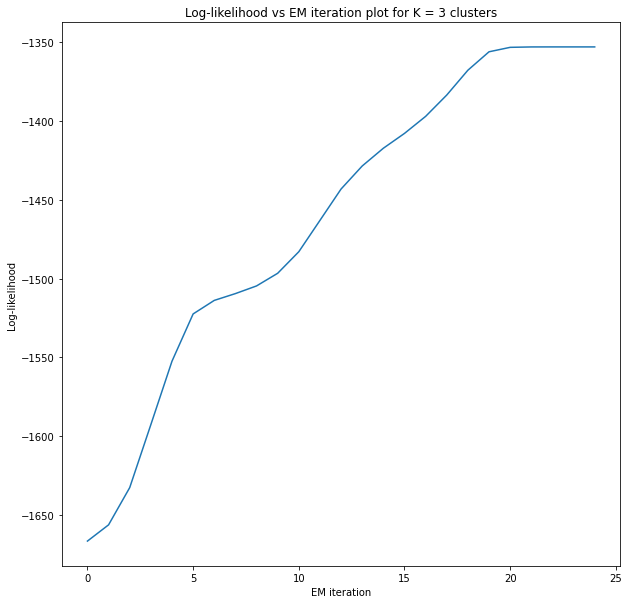

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

For no of cluster 4 log-likelihood =  [-1432.6927155]
0.13900919334194653
For no of cluster 4 bic =  [2889.35128919]


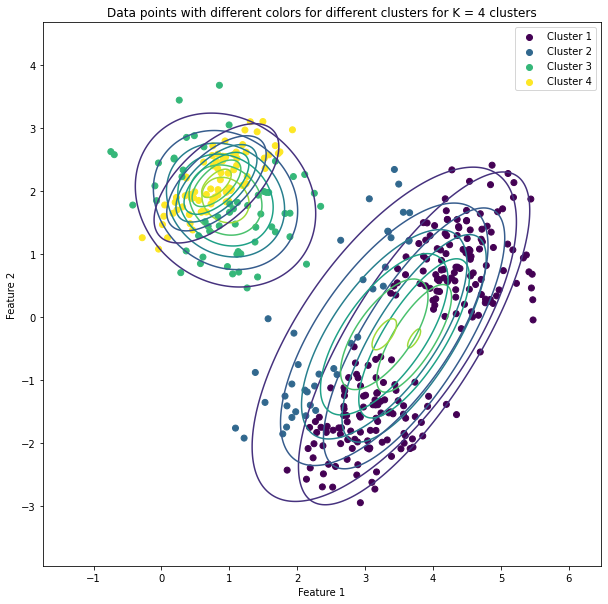

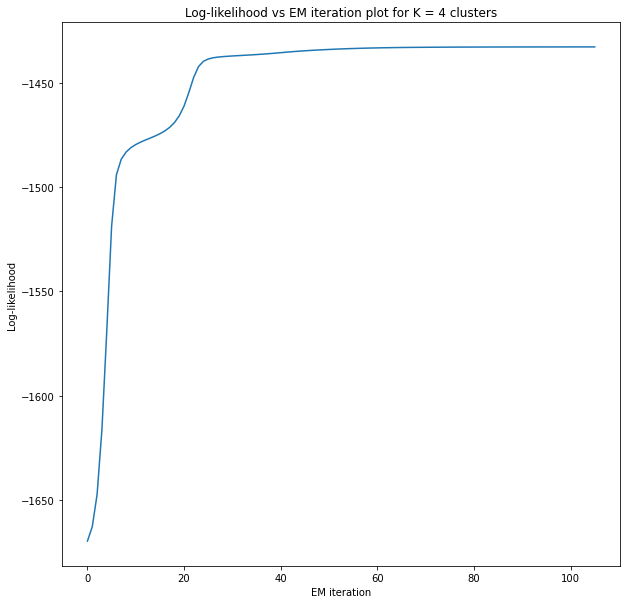

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

For no of cluster 5 log-likelihood =  [-1343.24689086]
0.365726036806617
For no of cluster 5 bic =  [2716.45110446]


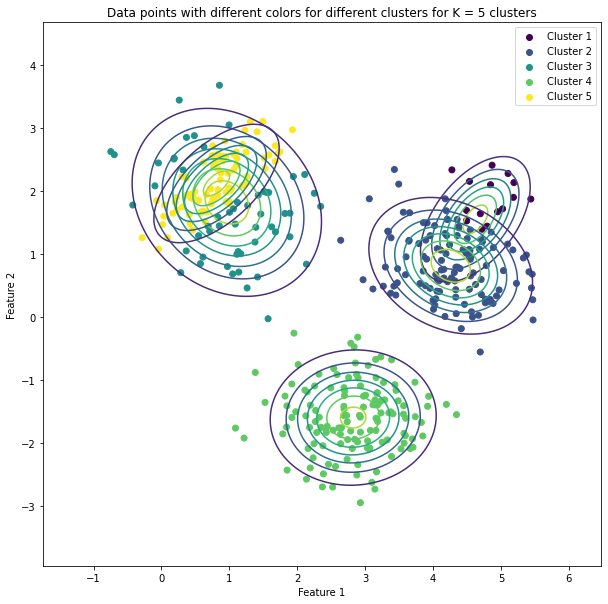

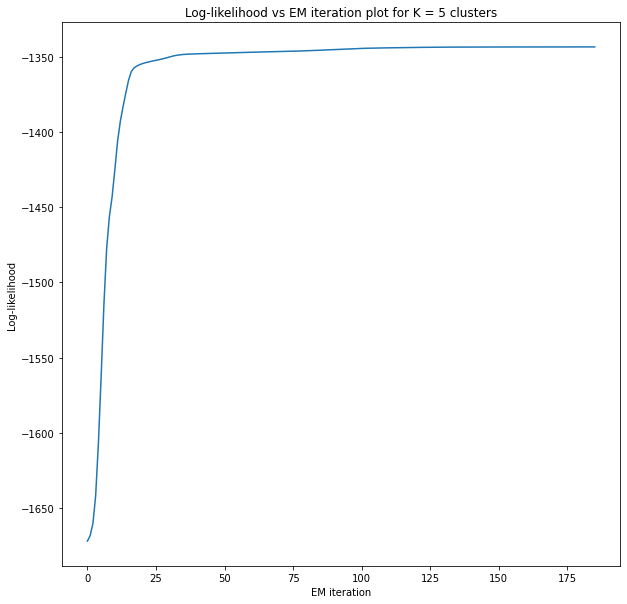

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

For no of cluster 6 log-likelihood =  [-1340.52457682]
0.33584881009900286
For no of cluster 6 bic =  [2716.99794092]


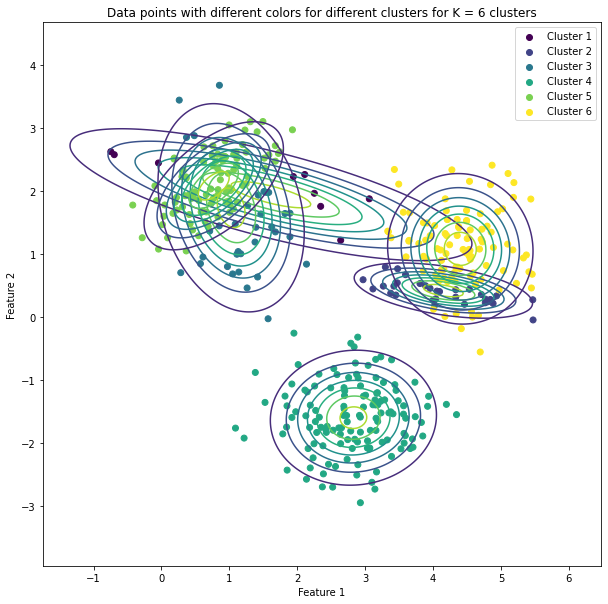

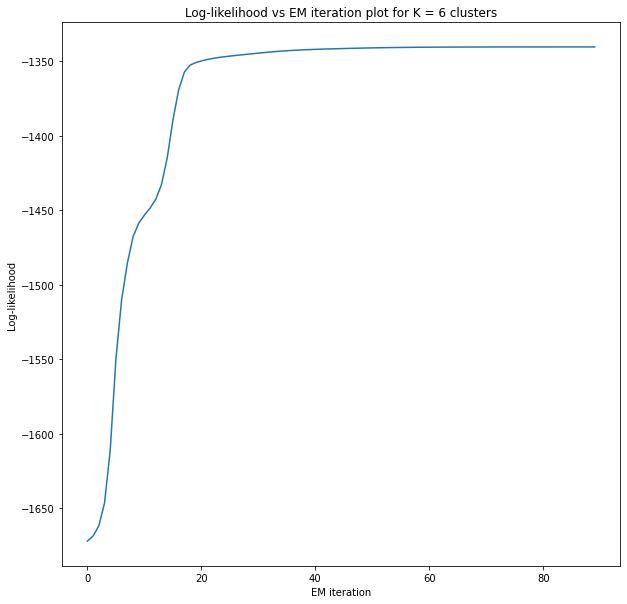

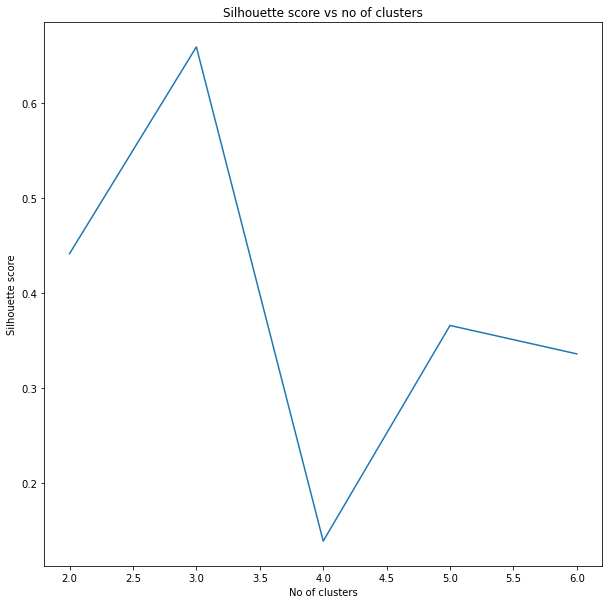

In [7]:
for i in range(2,7):
    pi,mean,cov,log_likelihood = GMM(1000,0.001,i,train_data)

plt.figure(figsize=(10,10))
plt.plot(np.arange(2,7), sic)
plt.title('Silhouette score vs no of clusters')
plt.xlabel('No of clusters')
plt.ylabel('Silhouette score')
plt.show()

# plt.figure(figsize=(10,10))
# plt.plot(np.arange(2,7), bic)
# plt.title('BIC vs no of clusters')
# plt.xlabel('No of clusters')
# plt.ylabel('BIC')
# plt.show()

